In [1]:
# TODO
# Find out why low avg rew, maybe because of minibatching?
# Test random seed just on data and just on model
# Add parallel envs of different sizes, with different data to help generality
# Amend env dist loss to allow for 100s of nodes in small area

In [2]:
%load_ext autoreload
%autoreload 2
%env WANDB_NOTEBOOK_NAME exploration.ipynb
%env WANDB_SILENT true

env: WANDB_NOTEBOOK_NAME=exploration.ipynb
env: WANDB_SILENT=true


In [3]:
import collections
import itertools
import os

import inept
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import wandb

# Set params
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Style
sns.set_theme(context='paper', style='white', palette='Set2')

# Script arguments
# import sys
# umb_mult = int(sys.argv[1])

In [4]:
# Original paper (pg 24)
# https://arxiv.org/pdf/1909.07528.pdf

# Original blog
# https://openai.com/research/emergent-tool-use

# Gym
# https://gymnasium.farama.org/

# Slides
# https://glouppe.github.io/info8004-advanced-machine-learning/pdf/pleroy-hide-and-seek.pdf

# PPO implementation
# https://github.com/nikhilbarhate99/PPO-PyTorch/blob/master/PPO.py#L38

# Residual SA
# https://github.com/openai/multi-agent-emergence-environments/blob/bafaf1e11e6398624116761f91ae7c93b136f395/ma_policy/layers.py#L89

In [5]:
# Reproducibility
seed = 42
torch.manual_seed(seed)
if DEVICE == 'cuda': torch.cuda.manual_seed(seed)
np.random.seed(seed)
# torch.backends.cudnn.deterministic=True

note_kwargs = {'seed': seed}

### Create Environment

In [6]:
# Load MMD-MA data
DATA_FOLDER = os.path.join(os.path.abspath(''), '../data')
M1 = pd.read_csv(os.path.join(DATA_FOLDER, 'UnionCom/MMD/s1_mapped1.txt'), delimiter='\t', header=None).to_numpy()
M2 = pd.read_csv(os.path.join(DATA_FOLDER, 'UnionCom/MMD/s1_mapped2.txt'), delimiter='\t', header=None).to_numpy()
T1 = pd.read_csv(os.path.join(DATA_FOLDER, 'UnionCom/MMD/s1_type1.txt'), delimiter='\t', header=None).to_numpy()
T2 = pd.read_csv(os.path.join(DATA_FOLDER, 'UnionCom/MMD/s1_type2.txt'), delimiter='\t', header=None).to_numpy()

# Data
num_nodes = 30
M1 = torch.rand((num_nodes, 8), device=DEVICE)
M2 = torch.rand((num_nodes, 16), device=DEVICE)
modalities = (M1, M2)

# Environment
# x, y, vx, vy
num_dims = 2
env = inept.environments.trajectory(*modalities, dim=num_dims, reward_type='euclidean', device=DEVICE)

# Data parameters
data_kwargs = {
    'num_nodes': num_nodes,
    'num_dims': num_dims,
}

### Train Policy

In [7]:
# Policy parameters
input_dims = 2*num_dims+sum([m.shape[1] for m in modalities])
update_minibatch = int( 4e4 * (10 / num_nodes) )
update_max_batch = 2 * update_minibatch
policy_kwargs = {
    'num_features_per_node': input_dims,
    'output_dim': num_dims,
    'action_std_init': .6,
    'action_std_decay': .05,
    'action_std_min': .1,
    'actor_lr': 3e-4,
    'critic_lr': 1e-3,
    'lr_gamma': 1,
    'update_minibatch': update_minibatch,  # Based on no minibatches needed with 10 nodes at 4k update timesteps
    'update_max_batch': update_max_batch,  # Try making larger, e.g. 20x minibatches
    'device': DEVICE,
}
policy = inept.models.PPO(**policy_kwargs)

# Training parameters
max_ep_timesteps = 2e2
max_timesteps = 1e6
update_timesteps = 20 * max_ep_timesteps
train_kwargs = {
    'max_ep_timesteps': max_ep_timesteps,
    'max_timesteps': max_timesteps,
    'update_timesteps': update_timesteps,
}
print(f'Subsampling {update_max_batch} states with minibatches of size {update_minibatch} from {int(update_timesteps * num_nodes)} total.')

# Early stopping parameters
es_kwargs = {
    'buffer': 3 * update_timesteps,
    'delta': .01,
}
early_stopping = inept.utilities.EarlyStopping(**es_kwargs)

# Initialize wandb
use_wandb = True
if use_wandb: wandb.init(
    project='INEPT',
    config={
        **{'note/'+k:v for k, v in note_kwargs.items()},
        **{'data/'+k:v for k, v in data_kwargs.items()},
        **{'policy/'+k:v for k, v in policy_kwargs.items()},
        **{'train/'+k:v for k, v in train_kwargs.items()},
        **{'es/'+k:v for k, v in es_kwargs.items()},
    },
)

# Initialize logging vars
torch.cuda.reset_peak_memory_stats()
timer = inept.utilities.time_logger(discard_first_sample=True)
timestep = 0; episode = 1; recording = collections.defaultdict(lambda: []); stats = collections.defaultdict(lambda: [])

# Simulation loop
print('Beginning training')
while timestep < max_timesteps:
    # Reset environment
    env.reset()
    timer.log('Reset Environment')

    # Start episode
    ep_timestep = 0; ep_reward = 0
    while ep_timestep < max_ep_timesteps:
        with torch.no_grad():
            # Get current state
            state = env.get_state(include_modalities=True)
            recording['states'].append(state.cpu().numpy())

            # Get self features for each node
            self_entity = state

            # Get node features for each state
            idx = torch.zeros((num_nodes, num_nodes), dtype=torch.bool)
            for i, j in itertools.product(*[range(x) for x in idx.shape]):
                idx[i, j] = i!=j
            node_entities = state.unsqueeze(0).expand(num_nodes, *state.shape)
            node_entities = node_entities[idx].reshape(num_nodes, num_nodes-1, input_dims)
            timer.log('Environment Setup')

            # Get actions from policy
            actions = policy.act(self_entity, node_entities).detach()
            timer.log('Calculate Actions')

            # Step environment and get reward
            rewards, finished = env.step(actions)
            timer.log('Step Environment')

            # Record rewards
            for key in range(num_nodes):
                policy.memory.rewards.append(rewards[key].item())  # Could just add lists
                policy.memory.is_terminals.append(finished)
            ep_reward = ep_reward + rewards.cpu().sum()
            recording['rewards'].append(rewards.cpu().numpy())
            timer.log('Record Rewards')

        # Iterate
        timestep += 1
        ep_timestep += 1

        # Update model
        if timestep % update_timesteps == 0:
            print(f'Updating model with average reward {np.mean(policy.memory.rewards)} on episode {episode} and timestep {timestep}', end='')
            policy.update()
            print(f' ({torch.cuda.max_memory_allocated() / 1024**3:.2f} GB)')
            torch.cuda.reset_peak_memory_stats()
            timer.log('Update Policy')

        # Escape if finished
        if finished: break

    # Record stats
    ep_reward = (ep_reward / (num_nodes * ep_timestep)).item()
    stats['episode'].append(episode)
    stats['end_timestep'].append(timestep)
    stats['average_reward'].append(ep_reward)
    stats['action_std'].append(policy.action_std)
    stats['update'].append(int(timestep / update_timesteps))

    if use_wandb:
        wandb.log({
            'episode': episode,
            'update': int(timestep / update_timesteps),
            'end_timestep': timestep,
            'average_reward': ep_reward,
            'action_std': policy.action_std,
        })
    timer.log('Record Stats')

    # Decay model std
    if early_stopping(ep_reward):
        # End if already at minimum
        if policy.action_std <= policy.action_std_min:
            print(f'Ending early on episode {episode} and timestep {timestep}')
            break

        # Decay and reset early stop
        policy.decay_action_std()
        early_stopping.reset()

        # CLI
        print(f'Decaying std to {policy.action_std} on episode {episode} and timestep {timestep}')
    timer.log('Early Stopping')

    # Iterate
    episode += 1

# CLI Timer
print()
timer.aggregate('sum')

Minibatching 80000 states from 20000 total.
Beginning training
Updating model with average reward -1.493209823935246 on episode 20 and timestep 4000 (0.71 GB)
Updating model with average reward -1.4425716947355802 on episode 40 and timestep 8000 (0.71 GB)
Updating model with average reward -1.3469991408043076 on episode 60 and timestep 12000 (0.71 GB)


In [ ]:
# Format states and stats
states = np.stack(recording['states'], axis=0)
rewards = np.array([rwds.mean() for rwds in recording['rewards']])
stats = pd.DataFrame(stats)

# Save model
MODEL_FOLDER = os.path.join(os.path.abspath(''), 'trained_models')
wgt_file = os.path.join(MODEL_FOLDER, 'policy.wgt')
torch.save(policy.state_dict(), wgt_file)  # Save just weights
if use_wandb: wandb.save(wgt_file)
mdl_file = os.path.join(MODEL_FOLDER, 'policy.mdl')
torch.save(policy, mdl_file)  # Save whole model (optimizers, action_std, etc.)
if use_wandb: wandb.save(mdl_file)

# Load model
# MODEL_FOLDER = os.path.join(os.path.abspath(''), 'trained_models')
# policy.load_state_dict(os.path.join(MODEL_FOLDER, 'this_run.wgt'))
# policy = torch.load(os.path.join(MODEL_FOLDER, 'this_run.mdl'))

['/home/thema/repos/inept/examples/wandb/run-20240410_225357-hn7mtlr1/files/trained_models/policy.mdl']

In [ ]:
# Finish wandb
if use_wandb: wandb.finish()

### Plot Performance

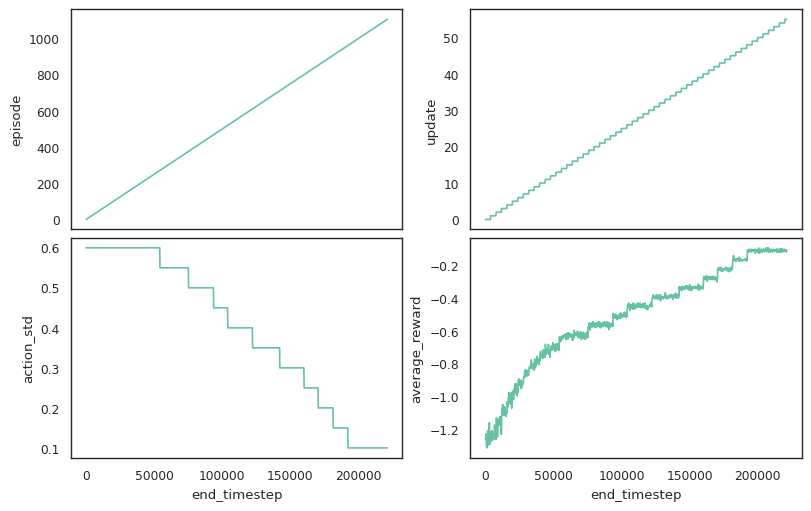

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=True, layout='constrained')
axs = axs.flatten()
sns.lineplot(stats, x='end_timestep', y='episode', ax=axs[0])
sns.lineplot(stats, x='end_timestep', y='update', ax=axs[1])
sns.lineplot(stats, x='end_timestep', y='action_std', ax=axs[2])
sns.lineplot(stats, x='end_timestep', y='average_reward', ax=axs[3])
plt.show()

### Animate Latent Space

In [ ]:
# Parameters
fraction_to_show = 1  # Show 1/`fraction_to_show` of the full runtime
skip = 1  # Only show 1 in every `skip` frames

# Subset
first_frame = max_ep_timesteps
last_frame = max_ep_timesteps-max_ep_timesteps/fraction_to_show+1
if ep_timestep != max_ep_timesteps:  # Adjust in case interrupted
    first_frame += ep_timestep
    last_frame += ep_timestep
anim_states = states[-int(first_frame):-int(last_frame):skip]
anim_rewards = rewards[-int(first_frame):-int(last_frame):skip]

# Create figure
fig, ax = plt.subplots(figsize=(5, 5), layout='constrained')
plt.sca(ax)

# Initial scatter
sct = ax.scatter(*anim_states[0, :, :num_dims].T)

# Update function
def update(frame):
    # Filter data
    sct.set_offsets(anim_states[frame, :, :num_dims])

    # Get rewards
    reward_from_frame = anim_rewards[frame]

    # Format
    ax.set_title(reward_from_frame)
    ax.set_aspect('equal')
    ax.set_xlim([-env.pos_bound-.2, env.pos_bound+.2])
    ax.set_ylim([-env.pos_bound-.2, env.pos_bound+.2])

    return sct

# Run animation
timescale = 3
ani = animation.FuncAnimation(fig=fig, func=update, frames=anim_states.shape[0], interval=skip*(1/timescale)*1000*env.delta)

# Save animation
PLOT_FOLDER = os.path.join(os.path.abspath(''), '../plots')
ani.save(os.path.join(PLOT_FOLDER, 'sample.gif'))
plt.close()

# Show animation
from IPython.display import HTML
HTML(ani.to_jshtml())

MovieWriter ffmpeg unavailable; using Pillow instead.
